## Analysis of thermodynamic trailblazing robustness
This notebook analyze the robustness of the trailblaze protocol in terms of how much does the discretization of the path varies from run to run.

In [1]:
%matplotlib inline

import glob
import math
import os

import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from utils.protocol import read_experiment_protocol, compute_average_protocol, plot_protocol

Load all the protocols generated by the trailblaze algorithm. We have run 5 replicates of all the receptor-ligand systems of CB8, T4-L99A, and BRD4(1) in the forward and reverse direction.

In [3]:
# Where to save the figures.
PLOTS_DIR_PATH = os.path.join('..', 'robustness_analysis', 'plots')

# Expected number of ligands, protocol variant of trailblaze runs, and replicates.
N_REPLICATES = 5
PROTOCOL_VARIANTS = ['forward05unidirectional', 'reverse05unidirectional',
                     'forward10unidirectional', 'reverse10unidirectional',
                     'forward20unidirectional', 'reverse20unidirectional',
                     'forward05bidirectional', 'reverse05bidirectional',
                     'forward10bidirectional', 'reverse10bidirectional',
                     'forward20bidirectional', 'reverse20bidirectional',]
RECEPTOR_TO_N_LIGANDS = {'CB8': 9, 'T4': 16, 'BRD4': 16}
TOTAL_N_LIGANDS = sum(RECEPTOR_TO_N_LIGANDS.values())
RECEPTOR_NAMES = list(RECEPTOR_TO_N_LIGANDS.keys())


def list_to_horizontal_str(l):
    """Work-around for iPython notebooks printing lists vertically."""
    return '[' + ', '.join(str(x) for x in l) + ']'


def print_protocol(p):
    """Shortcut for printing protocol in a readable format."""
    for par_name, values in p.items():
        print(par_name, ":", list_to_horizontal_str(values), '\n')


def load_all_protocols(experiments_dir_path):
    """Load the replicate trailblazed paths in the experiments/ folder in a dictionary.
    
    Returns
    -------
    protocols: Dict[str, Dict[str, List[Dict[str, List[float]]]]]
        protocols[protocol_variant][system_name][replicate_idx][lambda_variable] is a
        list of floats defining the protocol for the lambda_variable using
        the protocol_variant (e.g., thermodynamic distance, direction of the
        "equilibrium switching", and bidirectional distribution) for the system_name.
    """
    protocols = {protocol_variant: {} for protocol_variant in PROTOCOL_VARIANTS}
    
    # Load all protocols.
    for receptor_name, n_ligands in RECEPTOR_TO_N_LIGANDS.items():
        experiment_dir_pattern = os.path.join(experiments_dir_path, f'experiment-{receptor_name}-*', '*/')

        # Collect protocols for this system.
        for experiment_dir_path in sorted(glob.glob(experiment_dir_pattern)):
            # Load the path of a specific replicate.
            try:
                protocol = read_experiment_protocol(experiment_dir_path)['complex']
            except FileNotFoundError:
               print('Skipping', experiment_dir_path, 'as no trailblaze protocol could be found.')
               continue

            # Get the protocol name and the replicate from the experiment directory name.
            experiment_dir_name = os.path.basename(os.path.normpath(experiment_dir_path))
            try:
                variant, system_name, replicate = experiment_dir_name.split('_')
                replicate = int(replicate)
            except ValueError:  # Too many values to unpack.
                # The first replicate has no explicit replicate number in its dir path.
                variant, system_name = experiment_dir_name.split('_')
                replicate = 1
            
            # Better system name.
            try:
                ligand_idx = int(system_name[-2:])
            except ValueError:
                ligand_idx = int(system_name[-1])
            for receptor_name in RECEPTOR_TO_N_LIGANDS.keys():
                if receptor_name in system_name:
                    system_name = receptor_name + '-ligand' + str(ligand_idx)

            # Make sure the trailblaze algorithm was completed successfully.
            if protocol['lambda_sterics'][-1] != 0.0:
                print('Discarding protocol in', experiment_dir_path,
                      'because it was not completed. The partial path is:')
                print_protocol(protocol)

            # Save the protocol.
            if system_name not in protocols[variant]:
                # Initialize the replicates array.
                protocols[variant][system_name] = [None for _ in range(N_REPLICATES)]
            protocols[variant][system_name][replicate-1] = protocol

    # Check that all the systems were found.
    for variant, variant_protocols in protocols.items():
        assert len(variant_protocols) == TOTAL_N_LIGANDS, variant

        # Check that all replicates were found.
        for system_name, system_protocols in variant_protocols.items():
            n_replicates_found = sum([1 for p in system_protocols if p is not None])
            assert n_replicates_found == N_REPLICATES, f"{variant} - {system_name}"
    
    return protocols


def plot_all_protocols(all_protocols, plot_bidirectional=True, x_axis='state index',
                       filtered_system_names=None, renamed_systems=None, output_file_path=None):
    """Plot all the protocols, either unidirectional or bidirectional.
    
    Parameters
    ----------
    plot_bidirectional : bool, optional
        If True the bidirectional protocols are plotted instead of the
        unidirectional ones. Default is True.
    x_axis : 'state index' or 'thermo length'
        Whether to plot the number of states or the thermodynamic length
        as the x-axis.
    filtered_system_names : Set[str], optional
        If given, only the systems in this set are plotted.
    renamed_systems : Dict[str, str], optional
        If given, the system will be renamed to rename_system[system_name].
    """
    sns.set_context('notebook', font_scale=1.4)
    sns.set_style('whitegrid')

    paired_palette = plt.get_cmap('Paired').colors
    colors = {
        '05': {'forward': paired_palette[0], 'reverse': paired_palette[1]},
        '10': {'forward': paired_palette[2], 'reverse': paired_palette[3]},
        '20': {'forward': paired_palette[4], 'reverse': paired_palette[5]},
    }

    # Each column is a system, each row is a lambda parameter.
    if filtered_system_names is not None:
        n_ligands = len(filtered_system_names)
    else:
        n_ligands = TOTAL_N_LIGANDS
    n_cols = 3
    n_rows = 3 * int(math.ceil(n_ligands/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2.5*n_rows), sharex=True)#, sharey=True)

    # Print both forward and reverse protocols side by side.
    for variant_idx, (variant, systems_protocols) in enumerate(all_protocols.items()):
        # Extract direction and std threshold.
        direction, std_str, redistribution = variant[:7], variant[7:9], variant[9:]
        
        # Consider only the bidirectional or unidirectional protocols.
        if plot_bidirectional != (redistribution == 'bidirectional'):
            continue
        
        # Transform thermo length threshold label into a numeric value.
        if std_str == '05':
            std_threshold = 0.5
        elif std_str == '10':
            std_threshold = 1.0
        elif std_str == '20':
            std_threshold = 2.0
        
        if x_axis == 'state index':
            plotted_std_threshold = None
        elif x_axis == 'thermo length':
            plotted_std_threshold = std_threshold

        # Keep track of the number of systems (not filtered) that we actually plot.
        system_idx = 0
        for system_name, replicate_protocols in systems_protocols.items():
            # Keep only the filtered systems.
            if filtered_system_names is not None and system_name not in filtered_system_names:
                continue
            row_idx = 3 * int(system_idx / n_cols)
            col_idx = system_idx % n_cols
            system_idx += 1

            # Plot on the column associated with this system.
            ax = axes[row_idx:row_idx+3,col_idx]

            # Compute and plot the average protocol.
            # avg_protocol, std_protocol = compute_average_protocol(replicate_protocols)
            # plot_protocol(ax, avg_protocol,
            #               err_bar_protocol=std_protocol,
            #               err_bar_multiplier=2.0,  # 2 times the standard deviation.
            #               label=variant, color='C'+str(variant_idx))

            # Plot all replicate paths.
            for i, protocol in enumerate(replicate_protocols):
                # Add label only to the first one for the legend.
                if i == 0:
                    label = direction + ' (s={:.1f} kT)'.format(std_threshold)
                else:
                    label = None

                # Plot the total standard deviation instead of the state index on the x-axis.
                plot_protocol(ax, protocol, std_threshold=plotted_std_threshold,
                              color=colors[std_str][direction], alpha=0.5, label=label)

            # Set title and legend.
            if renamed_systems is not None:
                system_name = renamed_systems[system_name]
            axes[row_idx,col_idx].set_title(system_name)
            axes[row_idx,col_idx].legend()

    plt.tight_layout(h_pad=0.0)
    
    if output_file_path is not None:
        plt.savefig(output_file_path)
    
    plt.show()

Now plot all the replicate path as a function of the state index.

In [4]:
# Load data.
all_protocols = load_all_protocols(experiments_dir_path='../robustness_analysis/experiments')

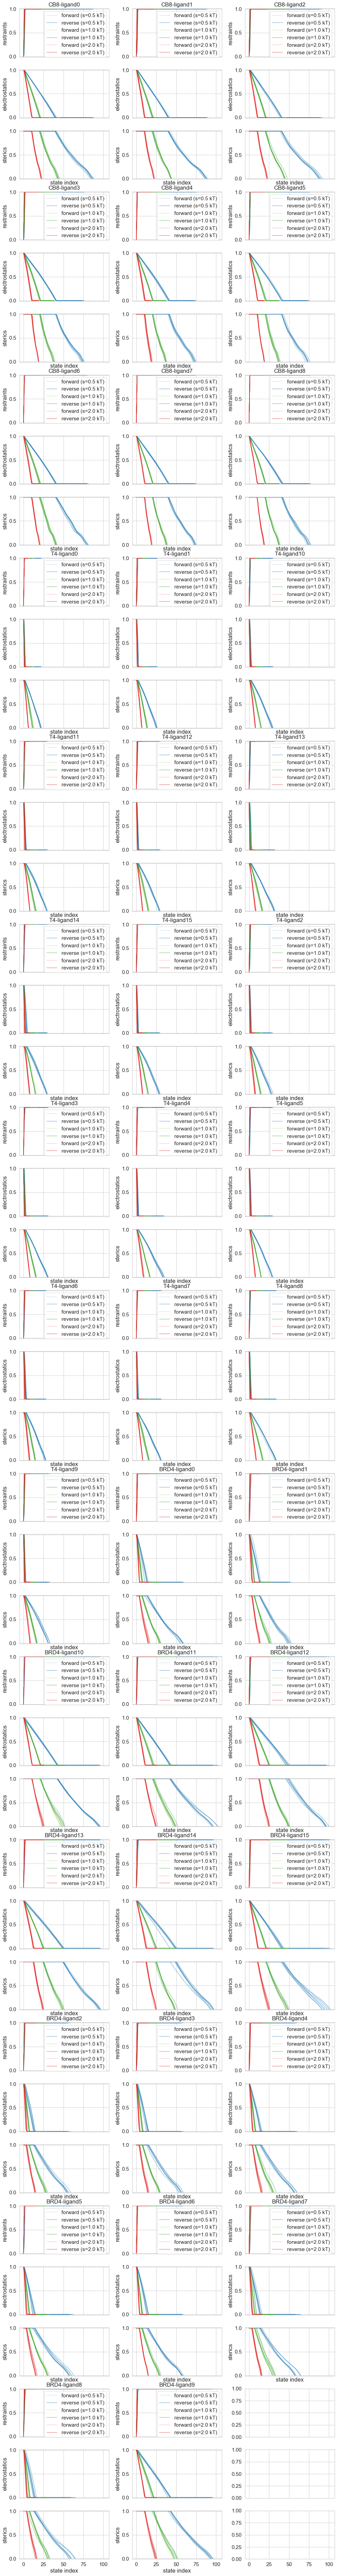

In [5]:
# Plot bidirectional.
plot_all_protocols(
    all_protocols, plot_bidirectional=True, x_axis='state index',
    output_file_path=os.path.join(PLOTS_DIR_PATH, 'trailblaze-robustness-bidirectional.pdf')
)

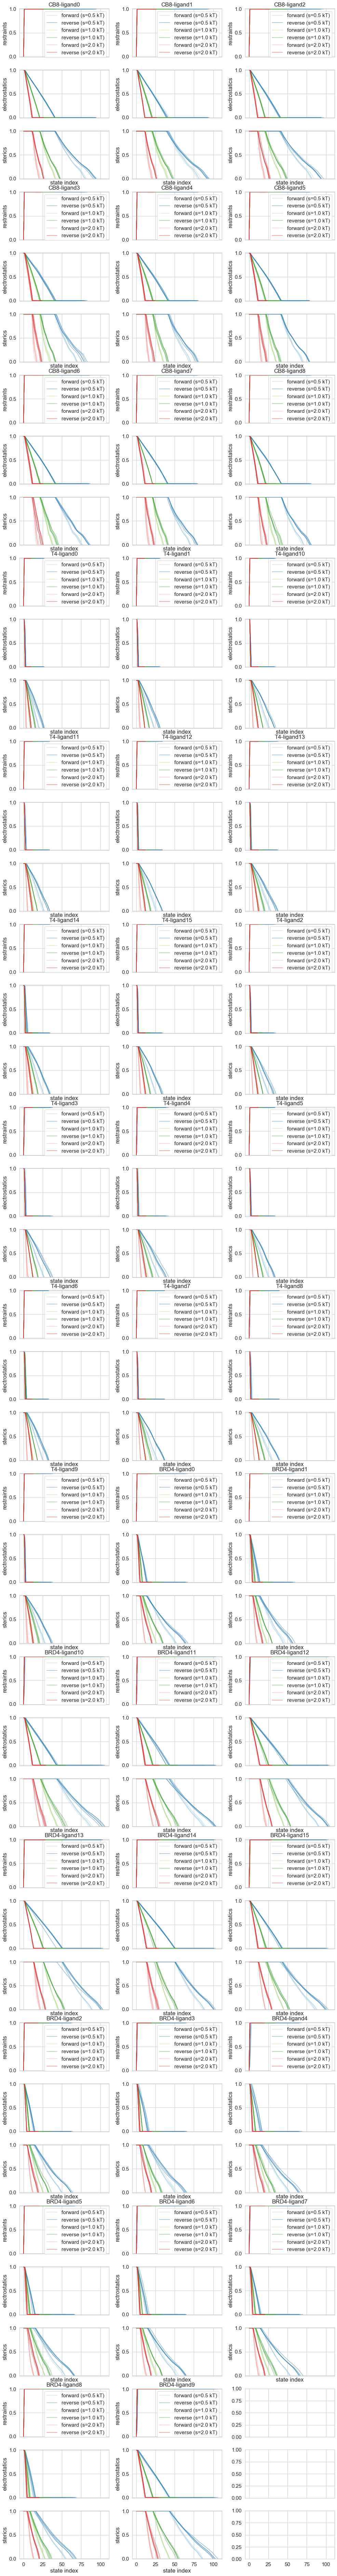

In [34]:
# Plot unidirectional.
plot_all_protocols(
    all_protocols, plot_bidirectional=False, x_axis='state index',
    output_file_path=os.path.join(PLOTS_DIR_PATH, 'trailblaze-robustness-unidirectional.pdf')
)

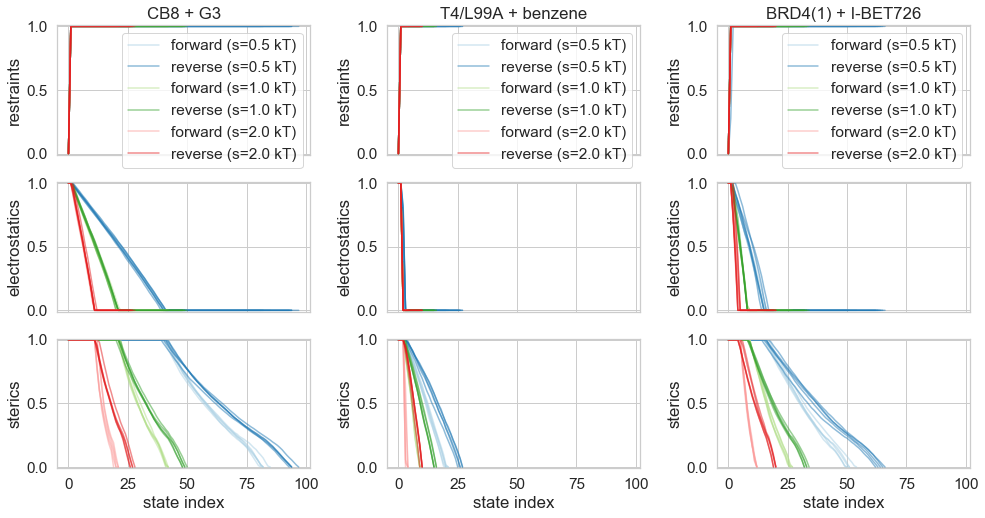

In [35]:
# Plot selected three.
renamed_systems = {
    'CB8-ligand2': 'CB8 + G3',
    'T4-ligand0': 'T4/L99A + benzene',
    'BRD4-ligand3': 'BRD4(1) + I-BET726'
}
plot_all_protocols(
    all_protocols, plot_bidirectional=False, x_axis='state index',
    filtered_system_names=set(renamed_systems.keys()),
    renamed_systems=renamed_systems,
    output_file_path=os.path.join(PLOTS_DIR_PATH, 'trailblaze-robustness-selected.pdf')
)